# Model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
# import seaborn as sns
from scipy.integrate import odeint
from scipy.optimize import fsolve
import scipy as sp
#from numba import jit  
#import wallEquations
# Functions

def QLossFunc(heatCoef,Area,Tbuilding,Toutside):
    """Returns the heat loss of spesific item

    Args:
        heatCoef (float): heat transfer coefficient
        Area (float): area of specific item
        Tbuilding (float): temperatur of building 
        Toutside (float): temperature outside

    Returns:
        float: Heat loss from specific item
    """
    return heatCoef*Area*(Tbuilding-Toutside)

def rhoRelative(T, rho0=1.1839, T0=298.15):
    """Returns the density of given T

    Args:
        rho0 (float): density of air at 1atm
        T0 (float): 25 degree celc
        T (float): input temperature

    Returns:
        float: density of input temperature
    """
    return (rho0*T0) / T

def specEnthalpy(T):
    return 30.184e3+10*(2501 + 1.84 * T)
def checkIfNegative(val):
    if val < 0:
        return 0
    return val

class model:
    # Global/Static variable
    qlossWalls = 0
    QlossRoof = 0
    QlossFloor = 0
    Qlossfur = 0
    def __init__(self, Toutside, peopleCount=1, airflow=0.7, dt=1, simTime=100, initBoundryTemp=20+273.15 ):
       
        # Time constants
        self.dt = dt
        self.deltaH = 1/self.dt 
        self.simulationTime = 0
        self.simTimeEnd = simTime

        # Building dimentions
        self.l = 3.65 # building length [m]
        self.w = 4 # building width [m]
        self.h = 3.3 # building height [m]

        self.Vb = self.l*self.h*self.w
        self.A = 2*(self.l*self.w) +2*(self.h*self.w) + 2*(self.h*self.l)
        # Other variables
        self.cPB = 1.005e3 # J/kg Specific heat capacity of moist air inside building
        self.R = 8.314472  # Pa m^3/ mol K Gas constant
        self.M_air = 28.97e-3 # [kg/mol] Molar mass of dry air
        self.M_H2O = 18e-3 # [kg/mol] Molar mass of water
        self.vIn = (airflow )/(3600*(self.l*self.w)) #(self.l*self.w)
        self.vOut = self.vIn
        self.eta = 0.7
        self.Cp_dryair=1006
        self.Cp_H2O=1840
        self.h_fg = 2260000
        self.Toutside = Toutside
        # Areas 
        self.Awindow = 1.2 # [m^2] Area of window
        self.Adoor = 0.75*2.1 # [m^2] Area of door
        self.Awalls = 2*(self.l+self.w)*self.h - (self.Awindow+self.Adoor) # [m^2] Area of walls
        self.Aroof = self.l*self.w # [m^2] Area of roof
        self.Afloor =  self.l*self.w # [m^2] Area of floor
        self.A = 2*(self.l*self.w) +2*(self.h*self.w) + 2*(self.h*self.l)
        
        # Overall heat transfer coefficients
        self.Uwindow = 1.2 # [W/m^2K] Heat transfer coeff of window
        self.Udoor = 1.2 # [W/m^2K] Heat transfer coeff of door
        self.Uwalls = 0.18 # [W/m^2K] Heat transfer coeff of walls
        self.Uroof = 0.13 # [W/m^2K] Heat transfer coeff of roof
        self.Ufloor =  0.15 # [W/m^2K] Heat transfer coeff of floor
        self.U = 1.2*2+0.18+0.13+0.15

        init_Temp = initBoundryTemp
        self.TwallInit = [init_Temp,init_Temp,init_Temp,init_Temp]
        self.TroofInit = [init_Temp,init_Temp,init_Temp,init_Temp]
        self.TfloorInit = [init_Temp,init_Temp,init_Temp]
        self.TfurInit = [init_Temp]

        self.lastTime = 0
        self.Qwalls = 0
        self.TempwallsLst = []
        self.AllWallTempLst = []
        self.Qroof = 0
        self.TemproofLst = []
        self.Qfloor = 0
        self.TempfloorLst = []
        self.Qfur = 0
        self.TempfurLst = []

        # Q gain factors
        self.Qheater = 0
        self.Qpeople = 0
        self.Qappliances = 150
        self.Qsolar = 0

        # Test values
        self.increment = np.array([0,0])
        self.ToutLst = list()
        self.ToutLst.append([0,self.Toutside])
        self.timer = 6

        self.heaterOnOffLst = []

        # More people values
        self.peopleCount = peopleCount

    def Qdot(self, Tb, time):
        """Returns heat loss and gain of all elements on specific room temperature

        Args:
            Tb (float): Room temperature at given time
        """
        # Heat loss
        self.Qwindow = QLossFunc(self.Uwindow, self.Awindow, Tb, self.Toutside) # W, 
        self.Qdoor = QLossFunc(self.Udoor, self.Adoor, Tb, self.Toutside) # W
        # self.Qwalls = QLossFunc(self.Uwalls, self.Awalls, Tb, self.Toutside) # W
        # self.Qfloor = QLossFunc(self.Ufloor, self.Afloor, Tb, self.Toutside) # W
        # self.Qroof = QLossFunc(self.Uroof, self.Aroof, Tb, self.Toutside) # W
        #hb = 2
        if self.lastTime < time: 
            t = np.arange(self.lastTime, self.lastTime+time)
            if time != 0:
                y0 = self.TwallInit
                y0 = odeint(self.Qloss_walls, y0, t,(self.Awalls, self.Tb, 2 ),rtol=1e-3,atol=1e-3)  
                self.Qwalls = checkIfNegative(model.qlossWalls)
                self.TwallInit = y0[-1]
                
                y02 = self.TroofInit
                y02 = odeint(self.Qloss_roof, y02, t,(self.Aroof, self.Tb, 2 ),rtol=1e-3,atol=1e-3)  
                self.Qroof = checkIfNegative(model.QlossRoof)
                self.TroofInit = y02[-1]

                y03 = self.TfloorInit
                y03 = odeint(self.Qloss_floor, y03, t,(self.Afloor, self.Tb, 2 ),rtol=1e-3,atol=1e-3)  
                self.Qfloor = checkIfNegative(model.QlossFloor)
                self.TfloorInit = y03[-1]

                y04 = self.TfurInit
                y04 = odeint(self.Qloss_furniture, y04, t,(0, self.Tb, 2 ),rtol=1e-3,atol=1e-3)  
                self.Qfur = checkIfNegative(model.Qlossfur)
                self.TfurInit = y04[-1]
                
        # Record temperature inside boudries
        self.TempwallsLst.append([time,self.TwallInit[0]])
        self.AllWallTempLst.append([time,self.TwallInit])
        self.TemproofLst.append([time,self.TroofInit[0]])
        self.TempfloorLst.append([time,self.TfloorInit[0]])
        self.TempfurLst.append([time,self.TfurInit[0]])

        self.Qloss = self.Qwindow + self.Qdoor + self.Qwalls + self.Qroof + self.Qfloor
        self.lastTime = time

        self.Qgain = self.Qheater + self.Qpeople + self.Qappliances + self.Qsolar
        self.Q = self.Qgain - self.Qloss
    
    def buildingModel(self, Tb, t, varyingOutdoorTemp=False):
        self.Tb = Tb
        
        rhoIn = self.rhoInFunc(self.Toutside)
        self.rhoIn = rhoIn
        rhoB = rhoRelative(self.Tb)
        self.rhoB = rhoB
        self.hIn, self.hOut  = self.h_Air()

        kelvin = 273.15
        if t <= 6.5*self.dt:
            self.vOut = self.vIn = 26/3600
            self.heaterControl(15+kelvin)
            self.Qpeople = 80
        elif t > 6.5*self.dt and t <= 8*self.dt:
            self.vInvOutUpdate(1.2)
            self.heaterControl(20+kelvin)
            self.Qpeople = 80
        elif t > 8*self.dt and t <= 16*self.dt:
            self.vInvOutUpdate(0.7)
            self.heaterControl(15+kelvin)
            self.Qpeople = 0
        elif t > 16*self.dt and t <= 23*self.dt:
            self.vInvOutUpdate(1.2)
            self.heaterControl(20+kelvin)
            self.Qpeople = 80*self.peopleCount
        # elif t > 19*self.dt and t <= 23*self.dt:
        #     self.vInvOutUpdate(1.2)
        #     self.heaterControl(20+kelvin)
        #     self.Qpeople = 80         
        else:
            self.vOut = self.vIn = 26/3600
            self.heaterControl(15+kelvin)
            self.Qpeople = 80

        self.heaterOnOffLst.append([t,self.Qheater])

        # Solar
        if t >= 10*self.dt and t <= 14*self.dt:
            self.Qsolar = 100 * self.Awindow
        else:
            self.Qsolar = 0

        # Varying Outside temperature
        if varyingOutdoorTemp and t >= self.ToutLst[-1][0]:
          if t > self.timer*self.dt and t <= 8*self.dt:
              self.Toutside += 0.1
              self.ToutLst.append([t,self.Toutside])
              self.timer += 0.1
          elif t > self.timer*self.dt and t <= 16*self.dt:
              self.Toutside += 0.12
              self.ToutLst.append([t,self.Toutside])
              self.timer += 0.1
          elif t > self.timer*self.dt and t <= 24*self.dt:
              self.Toutside -= 0.15
              self.ToutLst.append([t,self.Toutside])
              self.timer += 0.1

        # Update Q factor
        self.Qdot(self.Tb, t)

        dydt=self.dTbdt()
        return dydt


    def dTbdt(self):
        """Returns tempature of the room 
        
        """   
        #ventilation = (self.vIn*self.rhoIn*self.hIn - self.vOut*self.rhoB*self.hOut)
        deltaRhoB = (self.vIn*self.rhoIn-self.vOut*self.rhoB) / self.Vb

        firstPart = (self.vIn*self.rhoIn*self.hIn - self.vOut*self.rhoB*self.hOut + self.Q) / (self.Vb*self.rhoB*(self.Cp_air-(self.R/self.Mb))) - (self.Tb/self.rhoB)*deltaRhoB
        #secondPart = (self.Tb/self.rhoB)*deltaRhoB
        return firstPart

    def rhoInFunc(self, Toutside, RH_out=0.77, P=101325):
        #Coefficients to determine the saturation vapor pressure of water
        p1=5.2623e-09
        p2=-6.3323e-06
        p3=0.003072
        p4=-0.75032
        p5=92.195
        p6=-4556.2
        p7=91.59
    
        Psat = p1*pow(Toutside,6) + p2*pow(Toutside,5) + p3*pow(Toutside,4) + p4*pow(Toutside,3) + p5*pow(Toutside,2) + p6*Toutside + p7

        PH2O = RH_out*Psat              # [Pa] Vapor presure of water at considering temperature and pressure
        f_H2O_in = PH2O/P          # [moles of water vapor/moles of moist air] Molar fraction of water vapor in
        self.f_H2O_in = f_H2O_in

        M_in = self.M_air*(1-f_H2O_in) + self.M_H2O*f_H2O_in      # [kg/mol] Molar mass of incoming moist air
        Rho_in = P*M_in/(self.R*Toutside)   # [kg/m3] Density of inlet air
        return Rho_in

    def h_Air(self):
        """ Return specific enthalpy of incoming air
        """
        self.xi=self.f_H2O_in*self.M_H2O/(1-self.f_H2O_in)/self.M_air
        h_dryair=self.Cp_dryair*self.Toutside
        h_H2O=self.Cp_H2O*self.Toutside+self.h_fg
        h_air_in=h_dryair+self.xi*h_H2O

        xo=self.vIn*self.rhoIn*self.xi/(self.vOut*self.rhoB)

        h_air_out=self.Cp_dryair*self.Tb+xo*(self.Cp_H2O*self.Tb+self.h_fg)      
        self.Cp_air=self.Cp_dryair+self.Cp_H2O*xo

        f_H2O_out = (xo/self.M_H2O)/(xo/self.M_H2O+(1-xo)/self.M_air)
        M_out = self.M_air*(1-f_H2O_out) + self.M_H2O*f_H2O_out
        self.Mb = M_out

        return h_air_in, h_air_out
   
    def Qloss_walls(self, X, t, A,Tb, hb, Toutside=-2.2+273.15, change = 1, fsolveTol = 0.01):
        T1, T2, T3, T4 = X  # temperatures of wall layers

        hInf = 1#self.hIn #30.184e3+10*(2501 + 1.84 * Toutside)
        # Constants
        a1 = 1.7e-7*change
        a2 = 1.4e-6*change
        a3 = 2.25e-2*change
        a4 = 1.7e-7*change

        l1 = 6e-3
        l2 = 75e-3
        l3 = 8.5e-3
        l4 = 8.5e-3

        K1 = 0.14
        K2 = 0.038
        K3 = 0.026
        K4 = 0.14

        def surfaceTemp(ki,ki2,li,li2,Ti,Ti2):
            return ((ki/li)*Ti + (ki2/li2)*Ti2) / ((ki/li) + (ki2/li2))

        # Inner surface temperatures are currently computed as arithmetic
        # averages of the layer temperatures:
        T2_s = surfaceTemp(K1,K2,l1,l2,T1,T2) #0.5*(T1+T2)
        T3_s = surfaceTemp(K2,K3,l2,l3,T2,T3) #0.5*(T2+T3)
        T4_s = surfaceTemp(K3,K4,l3,l4,T3,T4) #0.5*(T3+T4)

        # Find temperatures of internal and external boundaries:
        def internalEquation(T_surface):
            return hb*(Tb-T_surface) - 0.5*K1*(T_surface-T2_s) / l1
        
        def externalEquation(T_surface):
            sigma = sp.constants.Stefan_Boltzmann
            eps = 0.8
            return hInf*A*(T_surface-Toutside) + sigma*eps*(T_surface**4 - Toutside**4) \
                                            - 0.5*K4*A*(T4_s - T_surface)/l4

        T1_s = fsolve(internalEquation, T2_s, xtol=fsolveTol)
        T5_s = fsolve(externalEquation, T4_s, xtol=fsolveTol)
        
        # Differential equations for wall layers:

        rhs1 = a1*(T2_s - 2*T1 + T1_s)/l1**2
        rhs2 = a2*(T3_s - 2*T2 + T2_s)/l2**2
        rhs3 = a3*(T4_s - 2*T3 + T3_s)/l3**2
        rhs4 = a4*(T5_s - 2*T4 + T4_s)/l4**2

        # Calculate Qloss
        
        model.qlossWalls = hb*A*(Tb-T1_s[-1]) # varme tap, NB! byttet TB og T1_s!!!!
        #print("self.Qwalls inside",self.Qwalls)
        #print(self.Qwalls)
        #print("t",t)
        return [rhs1, rhs2, rhs3, rhs4]
    
    def Qloss_roof(self, X, t, A, Tb, hb, Toutside=-2.2+273.15,change = 1, fsolveTol = 0.01):
        """
        Compute right-hand side of ODE system.
        """
        
        T1, T2, T3, T4 = X  # temperatures of wall layers

        hInf = 1#self.hIn #30.184e3+10*(2501 + 1.84 * Toutside)
        # Constants
        a1 = 1.7e-7*change
        a2 = 1.4e-6*change
        a3 = 1.8e-7*change
        a4 = 4e-7*change

        l1 = 6e-3
        l2 = 100e-3
        l3 = 11e-3
        l4 = 6.5e-4

        K1 = 0.14
        K2 = 0.038
        K3 = 0.12
        K4 = 0.027

        def surfaceTemp(ki,ki2,li,li2,Ti,Ti2):
            return ((ki/li)*Ti + (ki2/li2)*Ti2) / ((ki/li) + (ki2/li2))

        # Inner surface temperatures are currently computed as arithmetic
        # averages of the layer temperatures:
        T2_s = surfaceTemp(K1,K2,l1,l2,T1,T2) #0.5*(T1+T2)
        T3_s = surfaceTemp(K2,K3,l2,l3,T2,T3) #0.5*(T2+T3)
        T4_s = surfaceTemp(K3,K4,l3,l4,T3,T4) #0.5*(T3+T4)

        # Find temperatures of internal and external boundaries:
        
        def internalEquation(T_surface):
            return hb*(Tb-T_surface) - 0.5*K1*(T_surface-T2_s) / l1
        

        def externalEquation(T_surface):
            sigma = sp.constants.Stefan_Boltzmann
            eps = 0.8
            return hInf*A*(T_surface-Toutside) + sigma*eps*(T_surface**4 - Toutside**4) \
                                            - 0.5*K4*A*(T4_s - T_surface)/l4
        
        T1_s = fsolve(internalEquation, T2_s, xtol=fsolveTol)
        T5_s = fsolve(externalEquation, T4_s, xtol=fsolveTol)
        
        # Differential equations for wall layers:

        rhs1 = a1*(T2_s - 2*T1 + T1_s)/l1**2
        rhs2 = a2*(T3_s - 2*T2 + T2_s)/l2**2
        rhs3 = a3*(T4_s - 2*T3 + T3_s)/l3**2
        rhs4 = a4*(T5_s - 2*T4 + T4_s)/l4**2

        # Calculate Qloss
        model.QlossRoof = hb*A*(Tb-T1_s[-1])
        #print(Qloss)
        #print("t",t)

        return [rhs1, rhs2, rhs3, rhs4]
    
    def Qloss_floor(self, X, t, A, Tb, hb, q=0, Toutside=-2.2+273.15, change = 1, fsolveTol = 0.01):
            """
            Compute right-hand side of ODE system.
            """
            
            T1, T2, T3 = X  # temperatures of wall layers
            # Constants
            a1 = 4e-7*change
            a2 = 1.7e-7*change
            a3 = 1.4e-6*change

            l1 = 1e-3
            l2 = 9e-3
            l3 = 75e-3

            K1 = 0.027
            K2 = 0.14
            K3 = 0.038

            def surfaceTemp(ki,ki2,li,li2,Ti,Ti2):
                return ((ki/li)*Ti + (ki2/li2)*Ti2) / ((ki/li) + (ki2/li2))

            # Inner surface temperatures are currently computed as arithmetic
            # averages of the layer temperatures:
            T2_s = surfaceTemp(K1,K2,l1,l2,T1,T2) #0.5*(T1+T2)
            T3_s = surfaceTemp(K2,K3,l2,l3,T2,T3) #0.5*(T2+T3)
            T4_s = Toutside + 5 # average ground temp 5 degrees higher than outdoors

            # Find temperatures of internal and external boundaries:
            
            def internalEquation(T_surface):
                return hb*(Tb-T_surface) - 0.5*K1*(T_surface-T2_s) / l1
            
            T1_s = fsolve(internalEquation, T2_s, xtol=fsolveTol)

            # Heater variables
            rho1 = 55
            rho2 = 615
            rho3 = 32
            cp1 = 1210
            cp2 = 1317
            cp3 = 835
            # Differential equations for wall layers:

            rhs1 = a1*(T2_s - 2*T1 + T1_s)/l1**2 + q/(rho1*cp1)
            rhs2 = a2*(T3_s - 2*T2 + T2_s)/l2**2 + q/(rho2*cp2)
            rhs3 = a3*(T4_s - 2*T3 + T3_s)/l3**2 + q/(rho3*cp3)
            

            # Calculate Qloss
            model.QlossFloor = hb*A*(Tb-T1_s[-1])
            #print(Qloss)
            #print("t",t)

            return [rhs1, rhs2, rhs3]

    def Qloss_furniture(self, X, t, A, Tb, hb, Toutside=-2.2+273.15, change = 1, fsolveTol = 0.01):
        """
        Compute right-hand side of ODE system.
        """
        
        T1 = X  # temperatures of wall layers

        v = 1
        # Inner surface temperatures are currently computed as arithmetic
        # averages of the layer temperatures:
        #T2_s = 0.5*(T1+T2)
        T2_s = T1
        # Constants
        a1 = 1.8e-7*change

        r = np.cbrt((3*v)/(4*np.pi))
        l1 = r
        K1 = 2
 
        # Find temperatures of internal boundary:
        
        def outerLayer(T_surface):  
            return hb*(Tb-T_surface) - 0.5*K1*(T_surface-T2_s) / l1

        T1_s = fsolve(outerLayer, T2_s, xtol=fsolveTol)
        # Differential equations for wall layers:
        rhs1 = a1*(T2_s - 2*T1 + T1_s)/l1**2 + a1*(1/r)*((T2_s-T1_s)/(r))

        
        A = 4*np.pi*r**2
        # Calculate Qloss
        model.Qlossfur = hb*A*(Tb-T1_s[-1])
        #print(Qloss)
        #print("t",t)

        return rhs1

    def vInvOutUpdate(self, speed):
        self.vIn = (speed * 1)/(3600)*(self.l*self.w) #(self.l*self.w)
        self.vOut = self.vIn 
    def heaterControl(self, setTemp):
        if self.Tb < setTemp-1:
            self.Qheater = 1000
            # if self.Tb < setTemp-2:
            #   self.Qheater = 2000
            #self.heaterOnOffLst.append(1)
        elif self.Tb > setTemp+1:
            self.Qheater = 0
            #self.heaterOnOffLst.append(0)



### Constant temperature

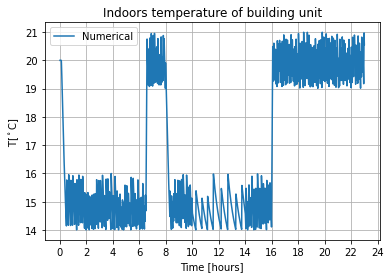

In [ ]:
from scipy.integrate import odeint

K = 273.15
dt = 60*60
simTime = 23*dt
tolerance = 1e-6

tSimArray=np.arange(0,simTime,1)
y0 = 20+K
Toutside = -2.2 + K #-2.2 +K
case2Model = model(Toutside,dt = dt,simTime=simTime )
solConstantTemp = odeint(case2Model.buildingModel, y0, tSimArray, rtol=tolerance,atol=tolerance) 

plt.grid()
plt.xticks(np.arange(0,24+1,2))

plt.plot(tSimArray/dt, solConstantTemp-K, label="Numerical")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

# plt.show()

In [ ]:
from scipy.integrate import odeint

K = 273.15
dt = 60*60
simTime = 23*dt
tolerance = 1e-6

tSimArray=np.arange(0,simTime,1)
y0 = 20+K
Toutside = -2.2 + K #-2.2 +K
case2Model = model(Toutside,dt = dt,simTime=simTime )
solStandard = odeint(case2Model.buildingModel, y0, tSimArray, rtol=tolerance,atol=tolerance) 



# plt.show()

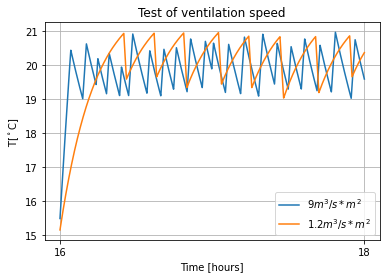

In [ ]:
plt.grid()
plt.xticks(np.arange(0,24+1,2))

plt.plot(tSimArray[16*dt:18*dt]/dt, solStandard[16*dt:18*dt]-K, label="$9m^3/s*m^2$")
plt.plot(tSimArray[16*dt:18*dt]/dt, solConstantTemp[16*dt:18*dt]-K, label="$1.2m^3/s*m^2$")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Test of ventilation speed")
plt.legend()

In [ ]:
np.array(solStandard)[16*dt]

array([288.63215953])

### Varying temperature

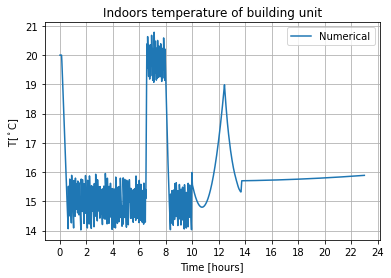

In [ ]:
from scipy.integrate import odeint

K = 273.15
dt = 60*60
simTime = 23*dt
tolerance = 1e-5

tSimArray=np.arange(0,simTime,1)
y0 = 20+K
Toutside = -2.2 + K #-2.2 +K
case2Model = model(Toutside,dt = dt,simTime=simTime )
solChangingTemp = odeint(case2Model.buildingModel, y0, tSimArray, args=(True, ), rtol=tolerance,atol=tolerance) 

plt.grid()
plt.xticks(np.arange(0,24+1,2))

plt.plot(tSimArray/dt, solChangingTemp-K, label="Numerical")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

0

### Indoors vs Outdoors temp plot

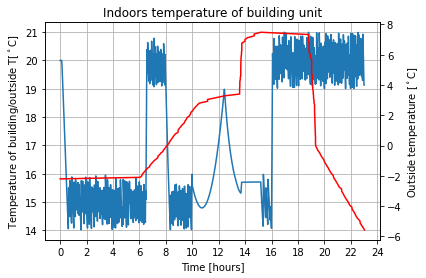

In [ ]:
fig, ax1 = plt.subplots()
plt.grid()
plt.title("Indoors temperature of building unit")

ax1.set_xlabel('Time [hours]')
ax1.set_ylabel('Temperature of building/outside T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
ax1.plot(tSimArray/dt, solChangingTemp-K, label="Numerical temperature")

ax2 = ax1.twinx()

OutsidetempList = case2Model.ToutLst

timeOutsidetempList = np.array([row[0] for row in OutsidetempList])
ValueOutsidetempList = np.array([row[1] for row in OutsidetempList])

ax2.plot(timeOutsidetempList/3600, ValueOutsidetempList-K, color='red')
ax2.set_ylabel('Outside temperature [$^\circ$C]')


#ax1.legend(loc="upper right")
plt.show()

In [ ]:
np.array(case2Model.ToutLst) - K

array([-95.])

### Compare with and without changing outdoors temp

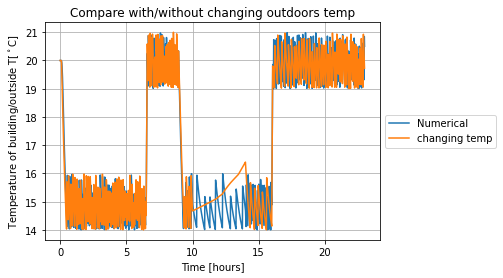

In [ ]:
plt.grid()
plt.title("Compare with/without changing outdoors temp")

plt.xlabel('Time [hours]')
plt.ylabel('Temperature of building/outside T[$^\circ$C]')
plt.xticks(np.arange((min(tSimArray)/dt)-5,(max(tSimArray)/dt)+5,5))
plt.plot(tSimArray/dt, solConstantTemp-K, label="Numerical")
plt.plot(tSimArray/dt, solChangingTemp-K, label="Changing temp")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Extreme temperatures

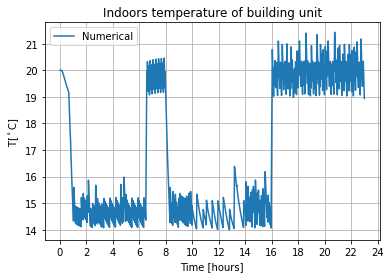

In [ ]:
from scipy.integrate import odeint

K = 273.15
dt = 60*60
simTime = 23*dt
tolerance = 1e-3 

tSimArray=np.arange(0,simTime,1)
y0 = 20+K
Toutside =  -2.2 + K # -2.2 +K # 60 + K #
case2Model = model(Toutside,dt = dt,simTime=simTime)
solConstantTemp = odeint(case2Model.buildingModel, y0, tSimArray, rtol=tolerance, atol=tolerance) 

plt.grid()
plt.xticks(np.arange(0,24+1,2))

plt.plot(tSimArray/dt, solConstantTemp-K, label="Numerical")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

# plt.show()

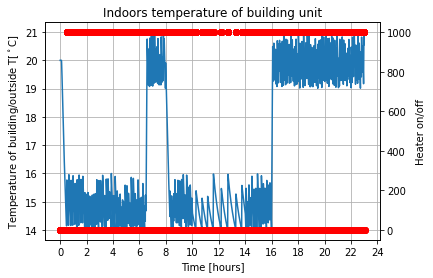

In [ ]:
heaterTemp = np.array(case2Model.heaterOnOffLst)

timeHeater = [row[0] for row in heaterTemp]
ValueHeater = [row[1] for row in heaterTemp]

fig, ax1 = plt.subplots()
plt.grid()
plt.title("Indoors temperature of building unit")

ax1.set_xlabel('Time [hours]')
ax1.set_ylabel('Temperature of building/outside T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
ax1.plot(tSimArray/dt, solConstantTemp-K, label="Numerical")

ax2 = ax1.twinx()

ax2.scatter(np.array(timeHeater)/dt, ValueHeater, color='red')
ax2.set_ylabel('Heater on/off')

plt.show()

In [ ]:
heaterTempLowerAirFlow = heaterTemp

In [ ]:
timeHeaterLowerAirFlow = [row[0] for row in heaterTempLowerAirFlow]
ValueHeaterLowerAirFlow = [row[1] for row in heaterTempLowerAirFlow]

timeHeater = [row[0] for row in heaterTemp1]
ValueHeater = [row[1] for row in heaterTemp1]

heaterTurnOnOffLst = [ValueHeaterLowerAirFlow,ValueHeater]

In [ ]:
unique, counts = np.unique(ValueHeater, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(ValueHeaterLowerAirFlow, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 10852, 1000.0: 6977}
{0.0: 11878, 1000.0: 6868}


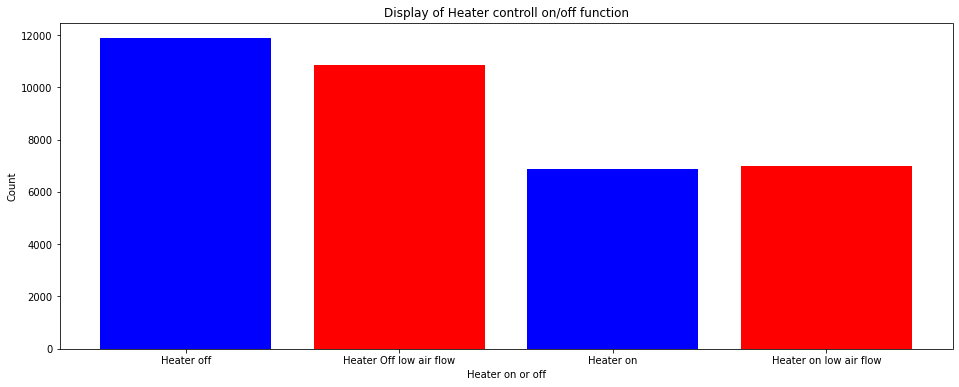

In [ ]:
def countOnOrOf(lst):
  nique, counts = np.unique(lst, return_counts=True)
  return dict(zip(unique, counts))

lowAirFlowDict = countOnOrOf(ValueHeaterLowerAirFlow)
rergAirFLoDict = countOnOrOf(ValueHeater)
barValLst = [lowAirFlowDict[0.0],rergAirFLoDict[0.0],lowAirFlowDict[1000.0],rergAirFLoDict[1000.0]]
colorArange = ["blue","red","blue","red"]
fig = plt.figure(figsize=(16, 6))

plt.title("Display of Heater controll on/off function")
plt.ylabel("Count")
plt.xlabel("Heater on or off")
#plt.bar(np.array(heaterTurnOnOffLst))
plt.bar(["Heater off", "Heater Off low air flow", "Heater on", "Heater on low air flow"], barValLst, color=colorArange)
plt.show()

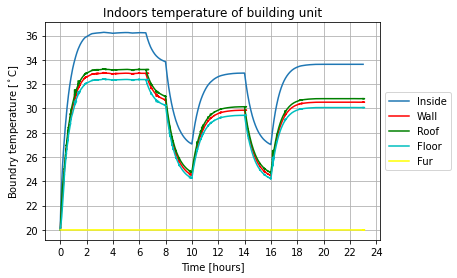

In [ ]:
wallTemp = np.array(case2Model.TempwallsLst)

timewallTemp = np.array([row[0] for row in wallTemp]
ValuewallTemp = np.array([row[1] for row in wallTemp])

roofTemp = np.array(case2Model.TemproofLst)

timeroofTemp = np.array([row[0] for row in roofTemp]
ValueroofTemp = np.array([row[1] for row in roofTemp])

floorTemp = np.array(case2Model.TempfloorLst)

timefloorTemp = np.array([row[0] for row in floorTemp]
ValuefloorTemp = np.array([row[1] for row in floorTemp])

furTemp = np.array(case2Model.TempfurLst)

timefurTemp = np.array([row[0] for row in furTemp]
ValuefurTemp = np.array([row[1] for row in furTemp])


fig, ax1 = plt.subplots()
plt.grid()
plt.title("Indoors temperature of building unit")

ax1.set_xlabel('Time [hours]')
ax1.set_ylabel('Temperature of building vs boundries T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
ax1.plot(tSimArray/dt, solConstantTemp-K, label="Inside")

#ax2 = ax1.twinx()

ax1.plot(timewallTemp/dt, ValuewallTemp-K, color='red', label="Wall" )
ax1.plot(timeroofTemp/dt, ValueroofTemp-K, color='green', label="Roof")
ax1.plot(timefloorTemp/dt, ValuefloorTemp-K, color='c', label="Floor")
ax1.plot(timefurTemp/dt, ValuefurTemp-K, color='yellow', label="Fur")
ax1.set_ylabel('Boundry temperature [$^\circ$C]')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


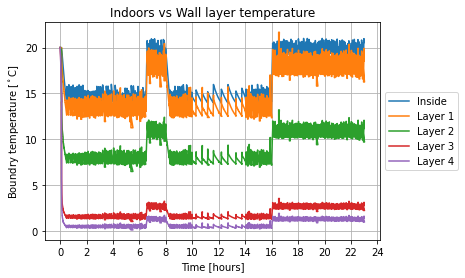

In [ ]:
AllwallTemp = np.array(case2Model.AllWallTempLst)

AlltimeWallTemp = np.array([row[0] for row in AllwallTemp])
AllValueTemps = np.array([row[1] for row in AllwallTemp])

fig, ax1 = plt.subplots()
plt.grid()
plt.title("Indoors vs Wall layer temperature")

ax1.set_xlabel('Time [hours]')
ax1.set_ylabel('Temperature T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
ax1.plot(tSimArray/dt, solConstantTemp-K, label="Inside")

#ax2 = ax1.twinx()

ax1.plot(AlltimeWallTemp/dt, AllValueTemps[:,0]-K, label="Layer 1" )
ax1.plot(AlltimeWallTemp/dt, AllValueTemps[:,1]-K, label="Layer 2" )
ax1.plot(AlltimeWallTemp/dt, AllValueTemps[:,2]-K, label="Layer 3" )
ax1.plot(AlltimeWallTemp/dt, AllValueTemps[:,3]-K, label="Layer 4" )
ax1.set_ylabel('Boundry temperature [$^\circ$C]')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

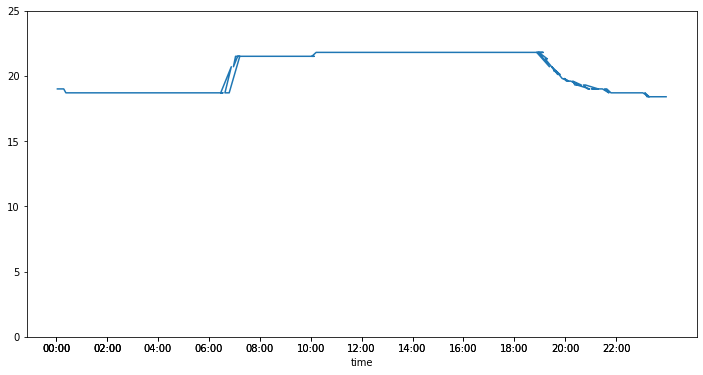

In [ ]:
åimport pandas as pd
import seaborn as sns

import datetime
plt.figure(figsize=(12, 6))

df = pd.read_csv('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_temp_2.csv')
df.time = pd.to_datetime(df.time)

dt = datetime.datetime(2021,3,3)
rows = df['time'].apply(
    lambda x: x.year == dt.year and x.month==dt.month and x.day== dt.day 
    )
dfmin = df[rows].copy()
idx = pd.date_range(dt, freq='2h', periods=26).strftime('%H:%M') 
dfmin.time = dfmin.time.dt.time
pd.plotting.register_matplotlib_converters()
plt.plot(dfmin.time, dfmin.value)

plt.xticks(idx)
plt.yticks(np.arange(0,30,5))


plt.show()

In [ ]:
pd.date_range(dt, freq='2h', periods=26).strftime('%H:%M')[-1]

'02:00'

In [ ]:
idx[-3]

'22:00'

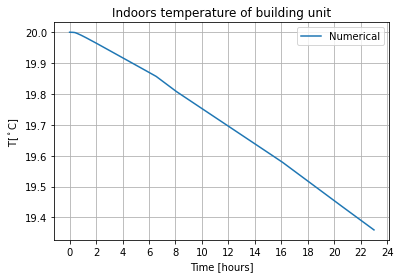

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
# import seaborn as sns
from scipy.integrate import odeint
from scipy.optimize import fsolve
import scipy as sp
#from numba import jit  
#import wallEquations
# Functions

def QLossFunc(heatCoef,Area,Tbuilding,Toutside):
    """Returns the heat loss of spesific item

    Args:
        heatCoef (float): heat transfer coefficient
        Area (float): area of specific item
        Tbuilding (float): temperatur of building 
        Toutside (float): temperature outside

    Returns:
        float: Heat loss from specific item
    """
    return heatCoef*Area*(Tbuilding-Toutside)

def rhoRelative(T, rho0=1.1839, T0=298.15):
    """Returns the density of given T

    Args:
        rho0 (float): density of air at 1atm
        T0 (float): 25 degree celc
        T (float): input temperature

    Returns:
        float: density of input temperature
    """
    return (rho0*T0) / T

def specEnthalpy(T):
    return 30.184e3+10*(2501 + 1.84 * T)
def checkIfNegative(val):
    if val < 0:
        return 0
    return val

class model:
    # Global/Static variable
    qlossWalls = 0
    QlossRoof = 0
    QlossFloor = 0
    Qlossfur = 0
    def __init__(self, Toutside, peopleCount=1, airflow=0.7, dt=1, simTime=100, initBoundryTemp=20+273.15 ):
       
        # Time constants
        self.dt = dt
        self.deltaH = 1/self.dt 
        self.simulationTime = 0
        self.simTimeEnd = simTime

        # Building dimentions
        self.l = 3.65*1000 # building length [m]
        self.w = 4*1000 # building width [m]
        self.h = 3.3*1000 # building height [m]

        self.Vb = self.l*self.h*self.w
        self.A = 2*(self.l*self.w) +2*(self.h*self.w) + 2*(self.h*self.l)
        # Other variables
        self.cPB = 1.005e3 # J/kg Specific heat capacity of moist air inside building
        self.R = 8.314472  # Pa m^3/ mol K Gas constant
        self.M_air = 28.97e-3 # [kg/mol] Molar mass of dry air
        self.M_H2O = 18e-3 # [kg/mol] Molar mass of water
        self.vIn = (airflow )/(3600*(self.l*self.w)) #(self.l*self.w)
        self.vOut = self.vIn
        self.eta = 0.7
        self.Cp_dryair=1006
        self.Cp_H2O=1840
        self.h_fg = 2260000
        self.Toutside = Toutside
        # Areas 
        self.Awindow = 1.2 # [m^2] Area of window
        self.Adoor = 0.75*2.1 # [m^2] Area of door
        self.Awalls = 2*(self.l+self.w)*self.h - (self.Awindow+self.Adoor) # [m^2] Area of walls
        self.Aroof = self.l*self.w # [m^2] Area of roof
        self.Afloor =  self.l*self.w # [m^2] Area of floor
        self.A = 2*(self.l*self.w) +2*(self.h*self.w) + 2*(self.h*self.l)
        
        # Overall heat transfer coefficients
        self.Uwindow = 1.2 # [W/m^2K] Heat transfer coeff of window
        self.Udoor = 1.2 # [W/m^2K] Heat transfer coeff of door
        self.Uwalls = 0.18 # [W/m^2K] Heat transfer coeff of walls
        self.Uroof = 0.13 # [W/m^2K] Heat transfer coeff of roof
        self.Ufloor =  0.15 # [W/m^2K] Heat transfer coeff of floor
        self.U = 1.2*2+0.18+0.13+0.15

        init_Temp = initBoundryTemp
        self.TwallInit = [init_Temp,init_Temp,init_Temp,init_Temp]
        self.TroofInit = [init_Temp,init_Temp,init_Temp,init_Temp]
        self.TfloorInit = [init_Temp,init_Temp,init_Temp]
        self.TfurInit = [init_Temp]

        self.lastTime = 0
        self.Qwalls = 0
        self.TempwallsLst = []
        self.AllWallTempLst = []
        self.Qroof = 0
        self.TemproofLst = []
        self.Qfloor = 0
        self.TempfloorLst = []
        self.Qfur = 0
        self.TempfurLst = []

        # Q gain factors
        self.Qheater = 0
        self.Qpeople = 0
        self.Qappliances = 150
        self.Qsolar = 0

        # Test values
        self.increment = np.array([0,0])
        self.ToutLst = list()
        self.ToutLst.append([0,self.Toutside])
        self.timer = 6

        self.heaterOnOffLst = []

        # More people values
        self.peopleCount = peopleCount

    def Qdot(self, Tb, time):
        """Returns heat loss and gain of all elements on specific room temperature

        Args:
            Tb (float): Room temperature at given time
        """
        # Heat loss
        self.Qwindow = QLossFunc(self.Uwindow, self.Awindow, Tb, self.Toutside) # W, 
        self.Qdoor = QLossFunc(self.Udoor, self.Adoor, Tb, self.Toutside) # W
        # self.Qwalls = QLossFunc(self.Uwalls, self.Awalls, Tb, self.Toutside) # W
        # self.Qfloor = QLossFunc(self.Ufloor, self.Afloor, Tb, self.Toutside) # W
        # self.Qroof = QLossFunc(self.Uroof, self.Aroof, Tb, self.Toutside) # W
        #hb = 2
        if self.lastTime < time: 
            t = np.arange(self.lastTime, self.lastTime+time)
            if time != 0:
                y0 = self.TwallInit
                y0 = odeint(self.Qloss_walls, y0, t,(self.Awalls, self.Tb, 2 ),rtol=1e-3,atol=1e-3)  
                self.Qwalls = checkIfNegative(model.qlossWalls)
                self.TwallInit = y0[-1]
                
                y02 = self.TroofInit
                y02 = odeint(self.Qloss_roof, y02, t,(self.Aroof, self.Tb, 2 ),rtol=1e-3,atol=1e-3)  
                self.Qroof = checkIfNegative(model.QlossRoof)
                self.TroofInit = y02[-1]

                y03 = self.TfloorInit
                y03 = odeint(self.Qloss_floor, y03, t,(self.Afloor, self.Tb, 2 ),rtol=1e-3,atol=1e-3)  
                self.Qfloor = checkIfNegative(model.QlossFloor)
                self.TfloorInit = y03[-1]

                y04 = self.TfurInit
                y04 = odeint(self.Qloss_furniture, y04, t,(0, self.Tb, 2 ),rtol=1e-3,atol=1e-3)  
                self.Qfur = checkIfNegative(model.Qlossfur)
                self.TfurInit = y04[-1]
                
        # Record temperature inside boudries
        self.TempwallsLst.append([time,self.TwallInit[0]])
        self.AllWallTempLst.append([time,self.TwallInit])
        self.TemproofLst.append([time,self.TroofInit[0]])
        self.TempfloorLst.append([time,self.TfloorInit[0]])
        self.TempfurLst.append([time,self.TfurInit[0]])

        self.Qloss = self.Qwindow + self.Qdoor + self.Qwalls + self.Qroof + self.Qfloor
        self.lastTime = time

        self.Qgain = self.Qheater + self.Qpeople + self.Qappliances + self.Qsolar
        self.Q = self.Qgain - self.Qloss
    
    def buildingModel(self, Tb, t, varyingOutdoorTemp=False):
        self.Tb = Tb
        
        rhoIn = self.rhoInFunc(self.Toutside)
        self.rhoIn = rhoIn
        rhoB = rhoRelative(self.Tb)
        self.rhoB = rhoB
        self.hIn, self.hOut  = self.h_Air()

        kelvin = 273.15
        if t <= 6.5*self.dt:
            self.vOut = self.vIn = 26/3600
            self.heaterControl(15+kelvin)
            self.Qpeople = 80
        elif t > 6.5*self.dt and t <= 8*self.dt:
            self.vInvOutUpdate(1.2)
            self.heaterControl(20+kelvin)
            self.Qpeople = 80
        elif t > 8*self.dt and t <= 16*self.dt:
            self.vInvOutUpdate(0.7)
            self.heaterControl(15+kelvin)
            self.Qpeople = 0
        elif t > 16*self.dt and t <= 23*self.dt:
            self.vInvOutUpdate(1.2)
            self.heaterControl(20+kelvin)
            self.Qpeople = 80*self.peopleCount
        # elif t > 19*self.dt and t <= 23*self.dt:
        #     self.vInvOutUpdate(1.2)
        #     self.heaterControl(20+kelvin)
        #     self.Qpeople = 80         
        else:
            self.vOut = self.vIn = 26/3600
            self.heaterControl(15+kelvin)
            self.Qpeople = 80

        self.heaterOnOffLst.append([t,self.Qheater])

        # Solar
        if t >= 10*self.dt and t <= 14*self.dt:
            self.Qsolar = 100 * self.Awindow
        else:
            self.Qsolar = 0

        # Varying Outside temperature
        if varyingOutdoorTemp and t >= self.ToutLst[-1][0]:
          if t > self.timer*self.dt and t <= 8*self.dt:
              self.Toutside += 0.1
              self.ToutLst.append([t,self.Toutside])
              self.timer += 0.1
          elif t > self.timer*self.dt and t <= 16*self.dt:
              self.Toutside += 0.12
              self.ToutLst.append([t,self.Toutside])
              self.timer += 0.1
          elif t > self.timer*self.dt and t <= 24*self.dt:
              self.Toutside -= 0.15
              self.ToutLst.append([t,self.Toutside])
              self.timer += 0.1

        # Update Q factor
        self.Qdot(self.Tb, t)

        dydt=self.dTbdt()
        return dydt


    def dTbdt(self):
        """Returns tempature of the room 
        
        """   
        #ventilation = (self.vIn*self.rhoIn*self.hIn - self.vOut*self.rhoB*self.hOut)
        deltaRhoB = (self.vIn*self.rhoIn-self.vOut*self.rhoB) / self.Vb

        firstPart = (self.vIn*self.rhoIn*self.hIn - self.vOut*self.rhoB*self.hOut + self.Q) / (self.Vb*self.rhoB*(self.Cp_air-(self.R/self.Mb))) - (self.Tb/self.rhoB)*deltaRhoB
        #secondPart = (self.Tb/self.rhoB)*deltaRhoB
        return firstPart

    def rhoInFunc(self, Toutside, RH_out=0.77, P=101325):
        #Coefficients to determine the saturation vapor pressure of water
        p1=5.2623e-09
        p2=-6.3323e-06
        p3=0.003072
        p4=-0.75032
        p5=92.195
        p6=-4556.2
        p7=91.59
    
        Psat = p1*pow(Toutside,6) + p2*pow(Toutside,5) + p3*pow(Toutside,4) + p4*pow(Toutside,3) + p5*pow(Toutside,2) + p6*Toutside + p7

        PH2O = RH_out*Psat              # [Pa] Vapor presure of water at considering temperature and pressure
        f_H2O_in = PH2O/P          # [moles of water vapor/moles of moist air] Molar fraction of water vapor in
        self.f_H2O_in = f_H2O_in

        M_in = self.M_air*(1-f_H2O_in) + self.M_H2O*f_H2O_in      # [kg/mol] Molar mass of incoming moist air
        Rho_in = P*M_in/(self.R*Toutside)   # [kg/m3] Density of inlet air
        return Rho_in

    def h_Air(self):
        """ Return specific enthalpy of incoming air
        """
        self.xi=self.f_H2O_in*self.M_H2O/(1-self.f_H2O_in)/self.M_air
        h_dryair=self.Cp_dryair*self.Toutside
        h_H2O=self.Cp_H2O*self.Toutside+self.h_fg
        h_air_in=h_dryair+self.xi*h_H2O

        xo=self.vIn*self.rhoIn*self.xi/(self.vOut*self.rhoB)

        h_air_out=self.Cp_dryair*self.Tb+xo*(self.Cp_H2O*self.Tb+self.h_fg)      
        self.Cp_air=self.Cp_dryair+self.Cp_H2O*xo

        f_H2O_out = (xo/self.M_H2O)/(xo/self.M_H2O+(1-xo)/self.M_air)
        M_out = self.M_air*(1-f_H2O_out) + self.M_H2O*f_H2O_out
        self.Mb = M_out

        return h_air_in, h_air_out
   
    def Qloss_walls(self, X, t, A,Tb, hb, Toutside=-2.2+273.15, change = 1, fsolveTol = 0.01):
        T1, T2, T3, T4 = X  # temperatures of wall layers

        hInf = 1#self.hIn #30.184e3+10*(2501 + 1.84 * Toutside)
        # Constants
        a1 = 1.7e-7*change
        a2 = 1.4e-6*change
        a3 = 2.25e-2*change
        a4 = 1.7e-7*change

        l1 = 6e-3
        l2 = 75e-3
        l3 = 8.5e-3
        l4 = 8.5e-3

        K1 = 0.14
        K2 = 0.038
        K3 = 0.026
        K4 = 0.14

        def surfaceTemp(ki,ki2,li,li2,Ti,Ti2):
            return ((ki/li)*Ti + (ki2/li2)*Ti2) / ((ki/li) + (ki2/li2))

        # Inner surface temperatures are currently computed as arithmetic
        # averages of the layer temperatures:
        T2_s = surfaceTemp(K1,K2,l1,l2,T1,T2) #0.5*(T1+T2)
        T3_s = surfaceTemp(K2,K3,l2,l3,T2,T3) #0.5*(T2+T3)
        T4_s = surfaceTemp(K3,K4,l3,l4,T3,T4) #0.5*(T3+T4)

        # Find temperatures of internal and external boundaries:
        def internalEquation(T_surface):
            return hb*(Tb-T_surface) - 0.5*K1*(T_surface-T2_s) / l1
        
        def externalEquation(T_surface):
            sigma = sp.constants.Stefan_Boltzmann
            eps = 0.8
            return hInf*A*(T_surface-Toutside) + sigma*eps*(T_surface**4 - Toutside**4) \
                                            - 0.5*K4*A*(T4_s - T_surface)/l4

        T1_s = fsolve(internalEquation, T2_s, xtol=fsolveTol)
        T5_s = fsolve(externalEquation, T4_s, xtol=fsolveTol)
        
        # Differential equations for wall layers:

        rhs1 = a1*(T2_s - 2*T1 + T1_s)/l1**2
        rhs2 = a2*(T3_s - 2*T2 + T2_s)/l2**2
        rhs3 = a3*(T4_s - 2*T3 + T3_s)/l3**2
        rhs4 = a4*(T5_s - 2*T4 + T4_s)/l4**2

        # Calculate Qloss
        
        model.qlossWalls = hb*A*(Tb-T1_s[-1]) # varme tap, NB! byttet TB og T1_s!!!!
        #print("self.Qwalls inside",self.Qwalls)
        #print(self.Qwalls)
        #print("t",t)
        return [rhs1, rhs2, rhs3, rhs4]
    
    def Qloss_roof(self, X, t, A, Tb, hb, Toutside=-2.2+273.15,change = 1, fsolveTol = 0.01):
        """
        Compute right-hand side of ODE system.
        """
        
        T1, T2, T3, T4 = X  # temperatures of wall layers

        hInf = 1#self.hIn #30.184e3+10*(2501 + 1.84 * Toutside)
        # Constants
        a1 = 1.7e-7*change
        a2 = 1.4e-6*change
        a3 = 1.8e-7*change
        a4 = 4e-7*change

        l1 = 6e-3
        l2 = 100e-3
        l3 = 11e-3
        l4 = 6.5e-4

        K1 = 0.14
        K2 = 0.038
        K3 = 0.12
        K4 = 0.027

        def surfaceTemp(ki,ki2,li,li2,Ti,Ti2):
            return ((ki/li)*Ti + (ki2/li2)*Ti2) / ((ki/li) + (ki2/li2))

        # Inner surface temperatures are currently computed as arithmetic
        # averages of the layer temperatures:
        T2_s = surfaceTemp(K1,K2,l1,l2,T1,T2) #0.5*(T1+T2)
        T3_s = surfaceTemp(K2,K3,l2,l3,T2,T3) #0.5*(T2+T3)
        T4_s = surfaceTemp(K3,K4,l3,l4,T3,T4) #0.5*(T3+T4)

        # Find temperatures of internal and external boundaries:
        
        def internalEquation(T_surface):
            return hb*(Tb-T_surface) - 0.5*K1*(T_surface-T2_s) / l1
        

        def externalEquation(T_surface):
            sigma = sp.constants.Stefan_Boltzmann
            eps = 0.8
            return hInf*A*(T_surface-Toutside) + sigma*eps*(T_surface**4 - Toutside**4) \
                                            - 0.5*K4*A*(T4_s - T_surface)/l4
        
        T1_s = fsolve(internalEquation, T2_s, xtol=fsolveTol)
        T5_s = fsolve(externalEquation, T4_s, xtol=fsolveTol)
        
        # Differential equations for wall layers:

        rhs1 = a1*(T2_s - 2*T1 + T1_s)/l1**2
        rhs2 = a2*(T3_s - 2*T2 + T2_s)/l2**2
        rhs3 = a3*(T4_s - 2*T3 + T3_s)/l3**2
        rhs4 = a4*(T5_s - 2*T4 + T4_s)/l4**2

        # Calculate Qloss
        model.QlossRoof = hb*A*(Tb-T1_s[-1])
        #print(Qloss)
        #print("t",t)

        return [rhs1, rhs2, rhs3, rhs4]
    
    def Qloss_floor(self, X, t, A, Tb, hb, q=0, Toutside=-2.2+273.15, change = 1, fsolveTol = 0.01):
            """
            Compute right-hand side of ODE system.
            """
            
            T1, T2, T3 = X  # temperatures of wall layers
            # Constants
            a1 = 4e-7*change
            a2 = 1.7e-7*change
            a3 = 1.4e-6*change

            l1 = 1e-3
            l2 = 9e-3
            l3 = 75e-3

            K1 = 0.027
            K2 = 0.14
            K3 = 0.038

            def surfaceTemp(ki,ki2,li,li2,Ti,Ti2):
                return ((ki/li)*Ti + (ki2/li2)*Ti2) / ((ki/li) + (ki2/li2))

            # Inner surface temperatures are currently computed as arithmetic
            # averages of the layer temperatures:
            T2_s = surfaceTemp(K1,K2,l1,l2,T1,T2) #0.5*(T1+T2)
            T3_s = surfaceTemp(K2,K3,l2,l3,T2,T3) #0.5*(T2+T3)
            T4_s = Toutside + 5 # average ground temp 5 degrees higher than outdoors

            # Find temperatures of internal and external boundaries:
            
            def internalEquation(T_surface):
                return hb*(Tb-T_surface) - 0.5*K1*(T_surface-T2_s) / l1
            
            T1_s = fsolve(internalEquation, T2_s, xtol=fsolveTol)

            # Heater variables
            rho1 = 55
            rho2 = 615
            rho3 = 32
            cp1 = 1210
            cp2 = 1317
            cp3 = 835
            # Differential equations for wall layers:

            rhs1 = a1*(T2_s - 2*T1 + T1_s)/l1**2 + q/(rho1*cp1)
            rhs2 = a2*(T3_s - 2*T2 + T2_s)/l2**2 + q/(rho2*cp2)
            rhs3 = a3*(T4_s - 2*T3 + T3_s)/l3**2 + q/(rho3*cp3)
            

            # Calculate Qloss
            model.QlossFloor = hb*A*(Tb-T1_s[-1])
            #print(Qloss)
            #print("t",t)

            return [rhs1, rhs2, rhs3]

    def Qloss_furniture(self, X, t, A, Tb, hb, Toutside=-2.2+273.15, change = 1, fsolveTol = 0.01):
        """
        Compute right-hand side of ODE system.
        """
        
        T1 = X  # temperatures of wall layers

        v = 1
        # Inner surface temperatures are currently computed as arithmetic
        # averages of the layer temperatures:
        #T2_s = 0.5*(T1+T2)
        T2_s = T1
        # Constants
        a1 = 1.8e-7*change

        r = np.cbrt((3*v)/(4*np.pi))
        l1 = r
        K1 = 2
 
        # Find temperatures of internal boundary:
        
        def outerLayer(T_surface):  
            return hb*(Tb-T_surface) - 0.5*K1*(T_surface-T2_s) / l1

        T1_s = fsolve(outerLayer, T2_s, xtol=fsolveTol)
        # Differential equations for wall layers:
        rhs1 = a1*(T2_s - 2*T1 + T1_s)/l1**2 + a1*(1/r)*((T2_s-T1_s)/(r))

        
        A = 4*np.pi*r**2
        # Calculate Qloss
        model.Qlossfur = hb*A*(Tb-T1_s[-1])
        #print(Qloss)
        #print("t",t)

        return rhs1

    def vInvOutUpdate(self, speed):
        self.vIn = (speed * 1)/(3600)*(self.l*self.w) #(self.l*self.w)
        self.vOut = self.vIn 
    def heaterControl(self, setTemp):
        if self.Tb < setTemp-1:
            self.Qheater = 6500*1000
            # if self.Tb < setTemp-2:
            #   self.Qheater = 2000
            #self.heaterOnOffLst.append(1)
        elif self.Tb > setTemp+1:
            self.Qheater = 0
            #self.heaterOnOffLst.append(0)

from scipy.integrate import odeint

K = 273.15
dt = 60*60
simTime = 23*dt
tolerance = 1e-6

tSimArray=np.arange(0,simTime,1)
y0 = 20+K
Toutside = -2.2 + K #-2.2 +K
case2Model = model(Toutside,dt = dt,simTime=simTime )
solConstantTemp = odeint(case2Model.buildingModel, y0, tSimArray, rtol=tolerance,atol=tolerance) 

plt.grid()
plt.xticks(np.arange(0,24+1,2))

plt.plot(tSimArray/dt, solConstantTemp-K, label="Numerical")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

# plt.show()
